In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Read in Data

In [2]:
# Read in Fifa and WIGGO Rankings
fifa_data = pd.read_csv('nb3a_fifa_data.csv')
wiggo_data = pd.read_csv('nb3b_wiggo_data.csv')
cv = KFold(5, random_state=42)

## Join Datasets

In [3]:
# Join datasets
joint_data = wiggo_data[4735:]

# Relabel WIGGO Info
joint_data = joint_data.rename(index=str, columns={"team_a_ranking": "wiggo_a_ranking",
                                                   "team_b_ranking": "wiggo_b_ranking",
                                                   "team_a_points": "wiggo_a_points",
                                                   "team_b_points": "wiggo_b_points"})
# Add FIFA Info
joint_data['fifa_a_ranking'] = fifa_data.team_a_ranking.values
joint_data['fifa_a_points'] = fifa_data.team_a_points.values
joint_data['fifa_b_ranking'] = fifa_data.team_b_ranking.values
joint_data['fifa_b_points'] = fifa_data.team_b_points.values

# Drop Categorical (already have dummies)
joint_data = joint_data.drop(columns={"Type"})

joint_data.describe()

,Unnamed: 0,HomeAdv,Win,PrevDiffHome1,PrevDiffAway1,PrevDiffHome2,PrevDiffAway2,PrevDiffHome3,PrevDiffAway3,PrevDiffHome4,...,Cont,ContQ,FSS,KFC,WM,WM-Q,fifa_a_ranking,fifa_a_points,fifa_b_ranking,fifa_b_points
count,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,...,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000
mean,7851.500000,0.713346,0.194257,0.034970,0.000962,0.040584,-0.000321,0.068335,-0.018608,0.064164,...,0.059673,0.161052,0.493423,0.005133,0.020533,0.260186,84.358037,509.415055,87.097530,488.747241
std,1799.745121,0.476084,0.849284,2.214126,2.192705,2.208262,2.192486,2.205069,2.199859,2.255618,...,0.236899,0.367609,0.499997,0.071468,0.141825,0.438771,55.385667,344.585517,55.029579,332.355653
min,4735.000000,-1.000000,-1.000000,-16.000000,-12.000000,-16.000000,-12.000000,-15.000000,-15.000000,-17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,6293.250000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,250.480000,40.000000,239.200000
50%,7851.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.000000,434.755000,81.000000,421.070000
75%,9409.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,126.000000,713.742500,129.000000,676.065000
max,10968.000000,1.000000,1.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,211.000000,1775.030000,211.000000,1775.030000


In [4]:
# Reorder Columns

joint_data = joint_data[['Win',
 'HomeAdv',
 'PrevDiffHome1',
 'PrevDiffHome2',
 'PrevDiffHome3',
 'PrevDiffHome4',
 'PrevDiffHome5',
 'PrevDiffHome6',
 'PrevDiffHome7',
 'PrevDiffHome8',
 'PrevDiffHome9',
 'PrevDiffHome10',
 'PrevDiffAway1',
 'PrevDiffAway2',
 'PrevDiffAway3',
 'PrevDiffAway4',
 'PrevDiffAway5',
 'PrevDiffAway6',
 'PrevDiffAway7',
 'PrevDiffAway8',
 'PrevDiffAway9',
 'PrevDiffAway10',
 'dist_home',
 'TravelHome',
 'TZDeltaHome',
 'dist_away',
 'TravelAway',
 'TZDeltaAway',
 'Cont',
 'ContQ',
 'FSS',
 'KFC',
 'WM',
 'WM-Q',
 'wiggo_a_ranking',
 'fifa_a_ranking',
 'wiggo_b_ranking',
 'fifa_b_ranking',
 'wiggo_a_points',
 'fifa_a_points',
 'wiggo_b_points',
 'fifa_b_points']]

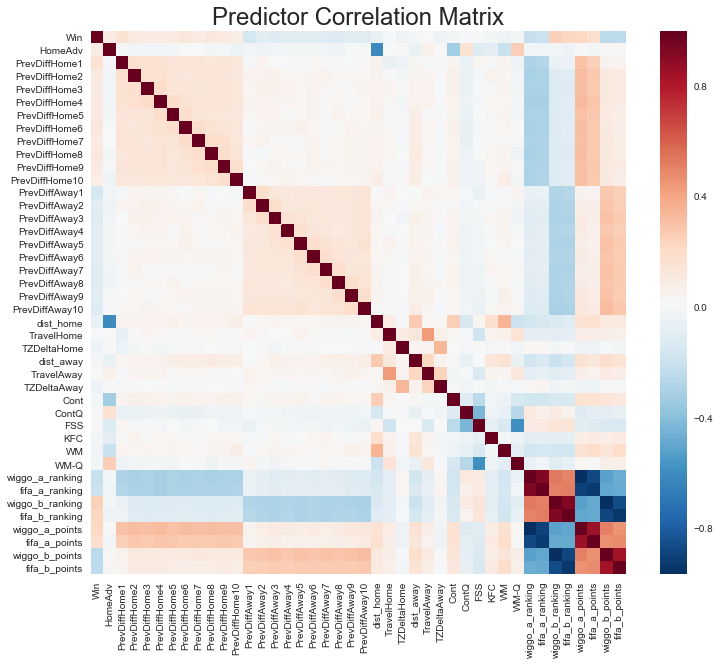

In [5]:
# Correlation Matrix

# Declare Plot
plt.figure(figsize = (12,10))

plt.title('Predictor Correlation Matrix', fontsize=24)

# Calculate Matrix
corr_matrix = np.corrcoef(joint_data.T)

# Create Heatmap
sns.heatmap(corr_matrix, cmap="RdBu_r", 
            xticklabels=joint_data.columns.values,
            yticklabels=joint_data.columns.values);

plt.savefig('correlation.png')

In [6]:
# Train - Test Split
y_train = joint_data.Win[joint_data.WM == 0].values + 1
y_test = joint_data.Win[(joint_data.WM == 1)].values + 1

x_train = joint_data[joint_data.WM == 0].drop(columns={'Win'})
x_test = joint_data[(joint_data.WM == 1)].drop(columns={'Win'})

# Ridge Classification

In [7]:
# declare and pass a KFold object to properly shuffle the training data 
# and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# Declare Lambdas
lambdas = [.001, .005, .1, .5, 1, 5, 10, 50, 100, 150, 200, 250]

# find the best shrinkage parameter
ridgeCV = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV.fit(x_train, y_train)

R_lambda = ridgeCV.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(R_lambda))

The shrinkage parameter 200 best fits our Ridge Regression model.


In [8]:
# Create subsets of the data
ranking_train = x_train[['fifa_a_ranking', 'wiggo_a_ranking',
                         'fifa_b_ranking', 'wiggo_b_ranking']]

ranking_test = x_test[['fifa_a_ranking', 'wiggo_a_ranking',
                         'fifa_b_ranking', 'wiggo_b_ranking']]

points_train = x_train[['fifa_a_points', 'wiggo_a_points',
                       'fifa_b_points', 'wiggo_b_points']]

points_test = x_test[['fifa_a_points', 'wiggo_a_points',
                       'fifa_b_points', 'wiggo_b_points']]

info_train = ranking_train.join(points_train)
info_test = ranking_test.join(points_test)

info_train.head()

,fifa_a_ranking,wiggo_a_ranking,fifa_b_ranking,wiggo_b_ranking,fifa_a_points,wiggo_a_points,fifa_b_points,wiggo_b_points
4735,114.0,105.0,158.0,156.0,260.28,1459.749020,112.14,1315.418259
4736,120.0,101.0,129.0,117.0,245.77,1478.784997,208.71,1438.584100
4737,108.0,94.0,88.0,87.0,298.87,1501.046264,364.41,1522.173904
4738,101.0,80.0,98.0,118.0,325.01,1536.269464,328.96,1432.569466
4739,106.0,111.0,158.0,140.0,307.77,1454.906951,111.79,1373.481424


In [9]:
## Ranking Only

# Declare Lambdas
lambdas = [.001, 1, 100, 1000, 10000, 50000, 100000]

# find the best shrinkage parameter
ridgeCV_ranking = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV_ranking.fit(ranking_train, y_train)

Ranking_lambda = ridgeCV_ranking.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(Ranking_lambda))

The shrinkage parameter 50000 best fits our Ridge Regression model.


In [10]:
## Points Only

# Declare Lambdas
lambdas = [.001, 1, 100, 1000, 10000, 50000, 100000]

# find the best shrinkage parameter
ridgeCV_points = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV_points.fit(points_train, y_train)

Points_lambda = ridgeCV_points.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(Points_lambda))

The shrinkage parameter 100000 best fits our Ridge Regression model.


In [11]:
## Ranking + Points

# Declare Lambdas
lambdas = [.001, 1, 100, 1000, 10000, 50000, 100000]

# find the best shrinkage parameter
ridgeCV_info = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV_info.fit(info_train, y_train)

Info_lambda = ridgeCV_info.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(Info_lambda))

The shrinkage parameter 100000 best fits our Ridge Regression model.


In [12]:
print("Training Scores\n")
print("Full Predictors:", ridgeCV.score(x_train[:], y_train[:]))
print("Rankings Only:", ridgeCV_ranking.score(ranking_train[:], y_train[:]))
print("Points Only:", ridgeCV_points.score(points_train[:], y_train[:]))
print("Rank + Points:", ridgeCV_info.score(info_train[:], y_train[:]))

Training Scores

Full Predictors: 0.5843432689158206
Rankings Only: 0.5722240419259744
Points Only: 0.5776285620700949
Rank + Points: 0.5771372420569931


In [36]:
print("Test Scores (2 World Cups)\n")
print("Full Predictors:", ridgeCV.score(x_test[:], y_test[:]))
print("Rankings Only:", ridgeCV_ranking.score(ranking_test[:], y_test[:]))
print("Points Only:", ridgeCV_points.score(points_test[:], y_test[:]))
print("Rank + Points:", ridgeCV_info.score(info_test[:], y_test[:]))

Test Scores (2 World Cups)

Full Predictors: 0.5859375
Rankings Only: 0.546875
Points Only: 0.578125
Rank + Points: 0.5703125


In [14]:
# Make lists
ridges = [ridgeCV, ridgeCV_ranking, ridgeCV_points, ridgeCV_info]
names = ['Full Predictors', 'Rankings Only', 'Points Only', 'Rankings + Points Only']
trains = [x_train, ranking_train, points_train, info_train]
tests = [x_test, ranking_test, points_test, info_test]

In [15]:
# Group & Report Accuracies
ridges = [ridgeCV, ridgeCV_ranking, ridgeCV_points, ridgeCV_info]
names = ['Full Predictors', 'Rankings Only', 'Points Only', 'Rankings + Points Only']
trains = [x_train, ranking_train, points_train, info_train]
tests = [x_test, ranking_test, points_test, info_test]

print("Ridge Classifier Results")
i = 0
for ridge in ridges:
    print("\n", names[i])
    print("Training Score    :", ridge.score(trains[i][:], y_train[:]))
    print("2014 (Val) Score  :", ridge.score(tests[i][:64], y_test[:64]))
    print("2018 (Test) Score :", ridge.score(tests[i][64:], y_test[64:]))
    i+=1

Ridge Classifier Results

 Full Predictors
Training Score    : 0.5843432689158206
2014 (Val) Score  : 0.578125
2018 (Test) Score : 0.59375

 Rankings Only
Training Score    : 0.5722240419259744
2014 (Val) Score  : 0.578125
2018 (Test) Score : 0.515625

 Points Only
Training Score    : 0.5776285620700949
2014 (Val) Score  : 0.625
2018 (Test) Score : 0.53125

 Rankings + Points Only
Training Score    : 0.5771372420569931
2014 (Val) Score  : 0.625
2018 (Test) Score : 0.515625


# More Classification Models

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

## Bagging

In [17]:
# Set seed
np.random.seed(42)

# Create DataFrames
bootstraps_class = pd.DataFrame()
bootstraps_class_val = pd.DataFrame()
bootstraps_class_test = pd.DataFrame()

# For 25 Bootstrap Samples
for i in range(25):
    
    # Generate Bootstrap Sample
    bootstrap = resample(x_train, y_train)
    
    # Fit Tree on Bootstrap Sample
    fit_tree_4 = DecisionTreeClassifier(max_depth=4)
    fit_tree_4.fit(bootstrap[0], bootstrap[1])

    # Store Class Predictions
    bootstraps_class['Bootstrap {} Preds'.format(i+1)] = fit_tree_4.predict(x_train)
    bootstraps_class_val['Bootstrap {} Preds'.format(i+1)] = fit_tree_4.predict(x_test[:64])
    bootstraps_class_test['Bootstrap {} Preds'.format(i+1)] = fit_tree_4.predict(x_test[64:])

In [18]:
# Check
np.sum(bootstraps_class_val.values == 1)

0

In [19]:
# Check
bootstraps_class_val.head()

,Bootstrap 1 Preds,Bootstrap 2 Preds,Bootstrap 3 Preds,Bootstrap 4 Preds,Bootstrap 5 Preds,Bootstrap 6 Preds,Bootstrap 7 Preds,Bootstrap 8 Preds,Bootstrap 9 Preds,Bootstrap 10 Preds,...,Bootstrap 16 Preds,Bootstrap 17 Preds,Bootstrap 18 Preds,Bootstrap 19 Preds,Bootstrap 20 Preds,Bootstrap 21 Preds,Bootstrap 22 Preds,Bootstrap 23 Preds,Bootstrap 24 Preds,Bootstrap 25 Preds
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [20]:
# Make meta-predictions
for row in range(len(bootstraps_class)):
    
    # Train
    bootstraps_class.at[row, 'MetaPred'] = round(np.mean(bootstraps_class.values[row][:25]))
    
for row in bootstraps_class_val.index:
    
    # Val
    bootstraps_class_val.at[row, 'MetaPred'] = round(np.mean(bootstraps_class_val.values[row][:25]))
    
    # Test
    bootstraps_class_test.at[row, 'MetaPred'] = round(np.mean(bootstraps_class_test.values[row][:25]))

In [21]:
from sklearn.metrics import accuracy_score

# Report Bagging Accuracy
print('Aggregated Classification Accuracy (Val) : {}'
      .format(round(accuracy_score(bootstraps_class_val['MetaPred'], y_test[:64]), 3)))

print('Aggregated Classification Accuracy (Test): {}'
      .format(round(accuracy_score(bootstraps_class_test['MetaPred'], y_test[64:]), 3)))

Aggregated Classification Accuracy (Val) : 0.469
Aggregated Classification Accuracy (Test): 0.547


## Random Forest

In [22]:
# Set seed
np.random.seed(42)

# Fit Random Forest
fit_random = RandomForestClassifier(max_depth=5, n_estimators=25, oob_score=True)
fit_random.fit(x_train,y_train)

# Calculate Classification Accuracies
acc_random = fit_random.score(x_train,y_train)
acc_random_val = fit_random.score(x_test[:64],y_test[:64])
acc_random_test = fit_random.score(x_test[64:],y_test[64:])
acc_random_oob = fit_random.oob_score_

# Report Accuracy
print('Random Forest Classification Accuracy (Train): {}'.format(round(acc_random, 3)))
print('Random Forest Classification Accuracy (Val)  : {}'.format(round(acc_random_val, 3)))
print('Random Forest Classification Accuracy (Test) : {}'.format(round(acc_random_test, 3)))

Random Forest Classification Accuracy (Train): 0.589
Random Forest Classification Accuracy (Val)  : 0.594
Random Forest Classification Accuracy (Test) : 0.547


## AdaBoost

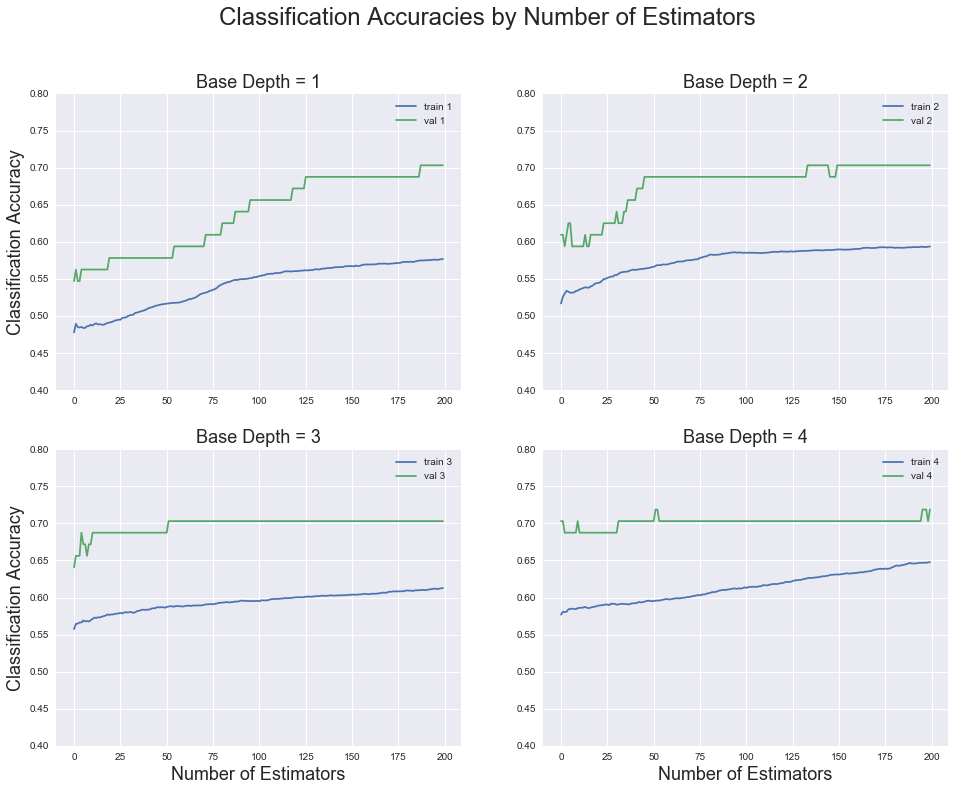

In [23]:
# Declare Accuracy Arrays
acc_ada = []
acc_ada_test = []

# Declare Plots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
i, j = 0, 0

for d in range(1, 5):
    
    # Fit Base Model
    fit_base = RandomForestClassifier(max_depth=d)
    
    # Fit AdaBoost Model
    fit_adaboost = AdaBoostClassifier(base_estimator=fit_base, learning_rate=.05, n_estimators=200)
    fit_adaboost.fit(x_train,y_train)
    
    # Calculate Accuracy
    acc_ada.append(fit_adaboost.score(x_train,y_train))
    acc_ada_test.append(fit_adaboost.score(x_test,y_test))
    
    # Set Correct Axes 
    if d == 2:
        j = 1
        
    if d == 3:
        i, j = 1, 0
        
    if d == 4:
        j = 1
    
    # Plot Number of Estimators vs Accuracy
    ax[i, j].plot(list(fit_adaboost.staged_score(x_train, y_train)), label='train {}'.format(d))
    ax[i, j].plot(list(fit_adaboost.staged_score(x_train[:64], y_train[:64])), label='val {}'.format(d))
    
    # Axes
    ax[i, j].set_ylim(.4, .8)
    
    # Legend & Title
    ax[i, j].set_title('Base Depth = {}'.format(d), fontsize=18)
    ax[i, j].legend()

# Label
ax[0, 0].set_ylabel('Classification Accuracy', fontsize=18)
ax[1, 0].set_ylabel('Classification Accuracy', fontsize=18)
ax[1, 0].set_xlabel('Number of Estimators', fontsize=18)
ax[1, 1].set_xlabel('Number of Estimators', fontsize=18)    
fig.suptitle('Classification Accuracies by Number of Estimators', fontsize=24);

In [24]:
# Fit base learner tree
fit_base = RandomForestClassifier(max_depth=4)

# Fit AdaBoost
fit_adaboost = AdaBoostClassifier(base_estimator=fit_base, learning_rate=.05, n_estimators=100)
fit_adaboost.fit(x_train,y_train)

# Calculate Classification Accuracy
acc_ada = fit_adaboost.score(x_train, y_train)
acc_ada_val = fit_adaboost.score(x_test[:64], y_test[:64])
acc_ada_test = fit_adaboost.score(x_test[64:], y_test[64:])

# Report Classification Accuracy
print('AdaBoost Classification Accuracy (Train): {}'.format(round(acc_ada, 3)))
print('AdaBoost Classification Accuracy (Val)  : {}'.format(round(acc_ada_val, 3)))
print('AdaBoost Classification Accuracy (Test) : {}'.format(round(acc_ada_test, 3)))

AdaBoost Classification Accuracy (Train): 0.614
AdaBoost Classification Accuracy (Val)  : 0.641
AdaBoost Classification Accuracy (Test) : 0.562


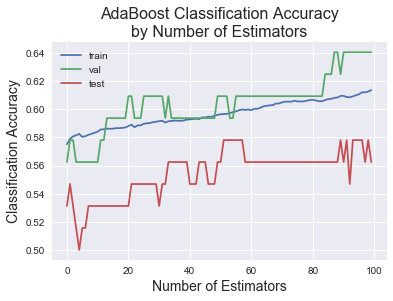

In [25]:
# Plot Number of Estimators vs Accuracy
plt.plot(list(fit_adaboost.staged_score(x_train, y_train)), label='train')
plt.plot(list(fit_adaboost.staged_score(x_test[:64], y_test[:64])), label='val')
plt.plot(list(fit_adaboost.staged_score(x_test[64:], y_test[64:])), label='test')

# Label
plt.title('AdaBoost Classification Accuracy\nby Number of Estimators', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Classification Accuracy', fontsize=14)
plt.legend()

plt.show()

## Ensemble

In [27]:
# Create Lists
models = [ridgeCV, fit_random, fit_adaboost]
names = ['Ridge', 'RF', 'AdaBoost', 'Bagging']
i = 0

# Create DataFrames
ensemble_tune = pd.DataFrame()
ensemble_val = pd.DataFrame()
ensemble_test = pd.DataFrame()

# For every model
for model in models:
    
    # Get Probabilities
    preds = model.predict(x_train)
    preds_val = model.predict(x_test[:64])
    preds_test = model.predict(x_test[64:])

    # Store Probability Predictions
    for row in range(len(x_train)):
        ensemble_tune.at[row, '{} Preds'.format(names[i])] = preds[row]
        
    for row in range(64):    
        ensemble_val.at[row, '{} Preds'.format(names[i])] = preds_val[row]
        ensemble_test.at[row, '{} Preds'.format(names[i])] = preds_test[row]
        
    # Progress
    print(names[i], "added!")
    i += 1
    
# Add Bagging Separately    
ensemble_tune['Bagging Preds'] = bootstraps_class['MetaPred']
ensemble_val['Bagging Preds'] = bootstraps_class_val['MetaPred']
ensemble_test['Bagging Preds'] = bootstraps_class_test['MetaPred']

print(names[i], "added!")
print("Done!")

Ridge added!
RF added!
AdaBoost added!
Bagging added!
Done!


In [28]:
# Check
ensemble_test.head()

,Ridge Preds,RF Preds,AdaBoost Preds,Bagging Preds
0,2.0,2.0,2.0,2.0
1,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,1.0
3,0.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0


In [29]:
# Fit Ensemble Logistic Regression
fit_logit = LogisticRegressionCV().fit(ensemble_tune, y_train)

# Calculate Classification Accuracy
acc_ens = fit_logit.score(ensemble_tune, y_train)
acc_ens_val = fit_logit.score(ensemble_val, y_test[:64])
acc_ens_test = fit_logit.score(ensemble_test, y_test[64:])

# Report Accuracy
print('Ensemble Classification Accuracy (Tune): {}'.format(round(acc_ens, 3)))
print('Ensemble Classification Accuracy (Val) : {}'.format(round(acc_ens_val, 3)))
print('Ensemble Classification Accuracy (Test): {}'.format(round(acc_ens_test, 3)))

Ensemble Classification Accuracy (Tune): 0.594
Ensemble Classification Accuracy (Val) : 0.609
Ensemble Classification Accuracy (Test): 0.547


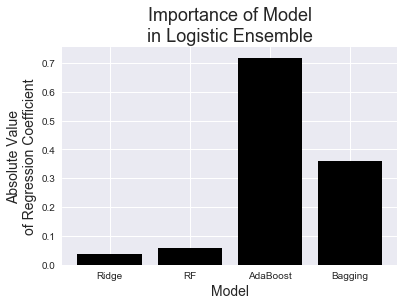

In [30]:
# Plot Regression Coefficients
plt.bar(names, abs(fit_logit.coef_[0]), color='black')

# Label
plt.title("Importance of Model\nin Logistic Ensemble", fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Absolute Value\nof Regression Coefficient', fontsize=14)

plt.show()

## Augmented Tree

In [32]:
# Create Augmented Dataset
aug_tune = x_train.reset_index()
del aug_tune['index']

aug_val = x_test[:64].reset_index()
del aug_val['index']
aug_test = x_test[64:].reset_index()
del aug_test['index']

aug_tune['Ridge Preds'] = ensemble_tune['Ridge Preds']
aug_tune['RF Preds'] = ensemble_tune['RF Preds']
aug_tune['AdaBoost Preds'] = ensemble_tune['AdaBoost Preds']
aug_tune['Bagging Preds'] = ensemble_tune['Bagging Preds']

aug_val['Ridge Preds'] = ensemble_val['Ridge Preds']
aug_val['RF Preds'] = ensemble_val['RF Preds']
aug_val['AdaBoost Preds'] = ensemble_val['AdaBoost Preds']
aug_val['Bagging Preds'] = ensemble_val['Bagging Preds']

aug_test['Ridge Preds'] = ensemble_test['Ridge Preds']
aug_test['RF Preds'] = ensemble_test['RF Preds']
aug_test['AdaBoost Preds'] = ensemble_test['AdaBoost Preds']
aug_test['Bagging Preds'] = ensemble_test['Bagging Preds']

In [33]:
# Check
aug_val.head()

,HomeAdv,PrevDiffHome1,PrevDiffHome2,PrevDiffHome3,PrevDiffHome4,PrevDiffHome5,PrevDiffHome6,PrevDiffHome7,PrevDiffHome8,PrevDiffHome9,...,wiggo_b_ranking,fifa_b_ranking,wiggo_a_points,fifa_a_points,wiggo_b_points,fifa_b_points,Ridge Preds,RF Preds,AdaBoost Preds,Bagging Preds
0,1,1,4,5,1,5,2,2,2,6,...,18.0,18.0,1936.556435,1242.23,1727.853778,903.47,2.0,2.0,2.0,2.0
1,0,-1,-1,-1,2,3,0,0,2,4,...,63.0,56.0,1744.454895,881.95,1582.069599,558.38,2.0,2.0,2.0,2.0
2,0,2,1,-1,-1,2,1,0,0,3,...,26.0,62.0,1787.152693,1026.23,1695.248920,525.60,2.0,2.0,2.0,2.0
3,0,2,2,1,-1,1,2,1,0,2,...,5.0,15.0,1923.489813,1484.58,1826.652967,981.24,2.0,2.0,2.0,2.0
4,0,2,1,0,0,5,1,-1,2,1,...,30.0,28.0,1800.019013,1147.48,1687.828086,762.48,2.0,2.0,2.0,2.0


In [34]:
# Fit tree model with depth 5
fit_aug = DecisionTreeClassifier(max_depth=5)
fit_aug.fit(aug_tune, y_train)

# Calculate Classification Accuracy
acc_aug = fit_aug.score(aug_tune, y_train)
acc_aug_val = fit_aug.score(aug_val, y_test[:64])
acc_aug_test = fit_aug.score(aug_test, y_test[64:])

# Report Classification Accuracy
print("Augmented Tree Classification Accuracy (Tune): {}".format(round(acc_aug, 3)))
print("Augmented Tree Classification Accuracy (Val) : {}".format(round(acc_aug_val, 3)))
print("Augmented Tree Classification Accuracy (Test): {}".format(round(acc_aug_test, 3)))

Augmented Tree Classification Accuracy (Tune): 0.617
Augmented Tree Classification Accuracy (Val) : 0.641
Augmented Tree Classification Accuracy (Test): 0.562


## Final Accuracies

In [35]:
# Report Accuracy

print("\nRidge Classification Accuracy (Train):", round(ridgeCV.score(x_train, y_train), 3))
print("Ridge Classification Accuracy (Val):", round(ridgeCV.score(x_test[:64], y_test[:64]), 3))
print("Ridge Classification Accuracy (Test):", round(ridgeCV.score(x_test[64:], y_test[64:]), 3))

print('\nBagging Classification Accuracy (Val) : {}'
      .format(round(accuracy_score(bootstraps_class_val['MetaPred'], y_test[:64]), 3)))
print('Bagging Classification Accuracy (Test): {}'
      .format(round(accuracy_score(bootstraps_class_test['MetaPred'], y_test[64:]), 3)))

print('\nAdaBoost Classification Accuracy (Train): {}'.format(round(acc_ada, 3)))
print('AdaBoost Classification Accuracy (Val)  : {}'.format(round(acc_ada_val, 3)))
print('AdaBoost Classification Accuracy (Test) : {}'.format(round(acc_ada_test, 3)))

print('\nRandom Forest Classification Accuracy (Train): {}'.format(round(acc_random, 3)))
print('Random Forest Classification Accuracy (Val)  : {}'.format(round(acc_random_val, 3)))
print('Random Forest Classification Accuracy (Test) : {}'.format(round(acc_random_test, 3)))

print('\nEnsemble Classification Accuracy (Tune): {}'.format(round(acc_ens, 3)))
print('Ensemble Classification Accuracy (Val) : {}'.format(round(acc_ens_val, 3)))
print('Ensemble Classification Accuracy (Test): {}'.format(round(acc_ens_test, 3)))

print("\nAugmented Tree Classification Accuracy (Tune): {}".format(round(acc_aug, 3)))
print("Augmented Tree Classification Accuracy (Val) : {}".format(round(acc_aug_val, 3)))
print("Augmented Tree Classification Accuracy (Test): {}".format(round(acc_aug_test, 3)))


Ridge Classification Accuracy (Train): 0.584
Ridge Classification Accuracy (Val): 0.578
Ridge Classification Accuracy (Test): 0.594

Bagging Classification Accuracy (Val) : 0.469
Bagging Classification Accuracy (Test): 0.547

AdaBoost Classification Accuracy (Train): 0.614
AdaBoost Classification Accuracy (Val)  : 0.641
AdaBoost Classification Accuracy (Test) : 0.562

Random Forest Classification Accuracy (Train): 0.589
Random Forest Classification Accuracy (Val)  : 0.594
Random Forest Classification Accuracy (Test) : 0.547

Ensemble Classification Accuracy (Tune): 0.594
Ensemble Classification Accuracy (Val) : 0.609
Ensemble Classification Accuracy (Test): 0.547

Augmented Tree Classification Accuracy (Tune): 0.617
Augmented Tree Classification Accuracy (Val) : 0.641
Augmented Tree Classification Accuracy (Test): 0.562
